## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to cast the polygons into np.arrays and afterwards transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
# Used to determine which part of the plot should be saved
from matplotlib.transforms import Bbox

# Used to underline text in plots
from matplotlib import rc
# To add a colorbar to the plot of the matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Used to navigate the directories and check for files
import os
# backup directory of this file, because the working directory is changed to save files
cor_mx_north_south_directory = os.getcwd()

## Get the Data
Read the file ["Readme.ipynb"](Readme.ipynb) or check out the files ["get_data.ipynb"](get_data.ipynb) and ["get_geographical_data_of_german_counties.ipynb"](get_geographical_data_of_german_counties.ipynb) for more information about the data collection.

In [2]:
os.chdir(".."), os.chdir("..")   # move two directories up
%run color_scheme.ipynb
os.chdir("collect_data")
%run get_data.ipynb
os.chdir(cor_mx_north_south_directory)    # return to original directory

Polished county data from file is ready to go!
Polished covid19 data from file is ready to go!


## Function to calculate the probability of correlations between two arrays

In [3]:
def old_sort_AdmUnitIDs_by_AdmUnitID_districts():
    long_districtIDs, short_districtIDs = (list(),list())
    for districtID in districts.keys():
        if len(districtID) == 2: short_districtIDs.append(districtID)
        elif len(districtID) == 3: long_districtIDs.append(districtID)
        else:
            raise Exception("The districtID '" + districtID +
                            "' seems to have more digits than expected.")
    long_districtIDs.sort(), short_districtIDs.sort()
    return  short_districtIDs + long_districtIDs

In [4]:
def sort_AdmUnitIDs_by_AdmUnitID_districts():
    districtIDs = [e for e in districts.keys()]
    districtIDs.sort()
    return districtIDs

In [5]:
# AdmUnitIds = list(covid19.keys())
AdmUnitIds = sort_AdmUnitIDs_by_AdmUnitID_districts()

In [10]:
districtIDs_sorted_by_ID = "\\begin{tabular}{c c}\n"
i=0
for districtID in AdmUnitIds:
    district_names = non_county_specific_data["district_names"]
    states_with_districts = [e[:-1] for e in district_names.keys()]
    # take state name instead of district, because state has no districts
    if districtID[:-1] in states_with_districts:
        district_name = non_county_specific_data["district_names"][districtID]
    else:
        districtID = districtID[:-1]
        district_name = non_county_specific_data["states"][districtID]
    districtIDs_sorted_by_ID += "    " + districtID + "&" + district_name + "\\\\ \n"
    if i==27:
        i=0
        districtIDs_sorted_by_ID += "\n\\end{tabular}\n\\newpage\n\\begin{tabular}{c c}\n"
    i += 1
districtIDs_sorted_by_ID += "\n\end{tabular}"

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
if not(os.path.isdir("results/txt-files")): os.makedirs("results/txt-files")
with open("results/txt-files/districtIDs_sorted_by_ID.tex", "w") as file:
    file.write(districtIDs_sorted_by_ID)
os.chdir(cor_mx_north_south_directory)    # return to original directory

In [7]:
def get_correlation_matrix(get_max_correlation_not_sum = True, max_shift = 50):
    correlation_matrix = [[0 for c2 in range(len(AdmUnitIds))]
                          for c1 in range(len(AdmUnitIds))]
    for AdmUnitId in AdmUnitIds:
        for second_AdmUnitId in AdmUnitIds:
            i1, i2 = (AdmUnitIds.index(AdmUnitId), AdmUnitIds.index(second_AdmUnitId))
            # if AdmUnitId1 == AdmUnitId2: continue
            if (correlation_matrix[i1][i2] != 0): continue    # Already set
            correlation = districts[AdmUnitId]["correlation"][second_AdmUnitId].copy()
            offset = max_shift + 1
            while get_max_correlation_not_sum and abs(offset) > max_shift:
                # get the shift with the highest correlation probability
                offset = non_county_specific_data[
                    "correlation_position_array2_to_array1"][np.argmax(correlation)]
                correlation[np.argmax(correlation)] = 0
            if not(get_max_correlation_not_sum):    # sum up all probabilities
                lc = len(correlation)//2
                if (len(correlation[:lc]) != len(correlation[lc+1:])):
                    raise Exception("Len(correlation) not correct)")
                if (len(correlation[lc-max_shift:lc]) !=
                    len(correlation[lc:lc+max_shift])):
                    raise Exception("Len(correlation) aslökdfjaslö")
                offset = (-sum(correlation[lc-max_shift:lc]) +
                          sum(correlation[lc:lc+max_shift]))
            correlation_matrix[i1][i2] = offset
            correlation_matrix[i2][i1] = -offset
    return correlation_matrix

In [8]:
correlation_matrizes = list()
matrix_configurations = [(False, 14), (True, 14), (False, 30), 
                         (True, 30),(False, 50), (True, 50)]
for config in matrix_configurations:
    correlation_matrizes.append(get_correlation_matrix(config[0], config[1]))

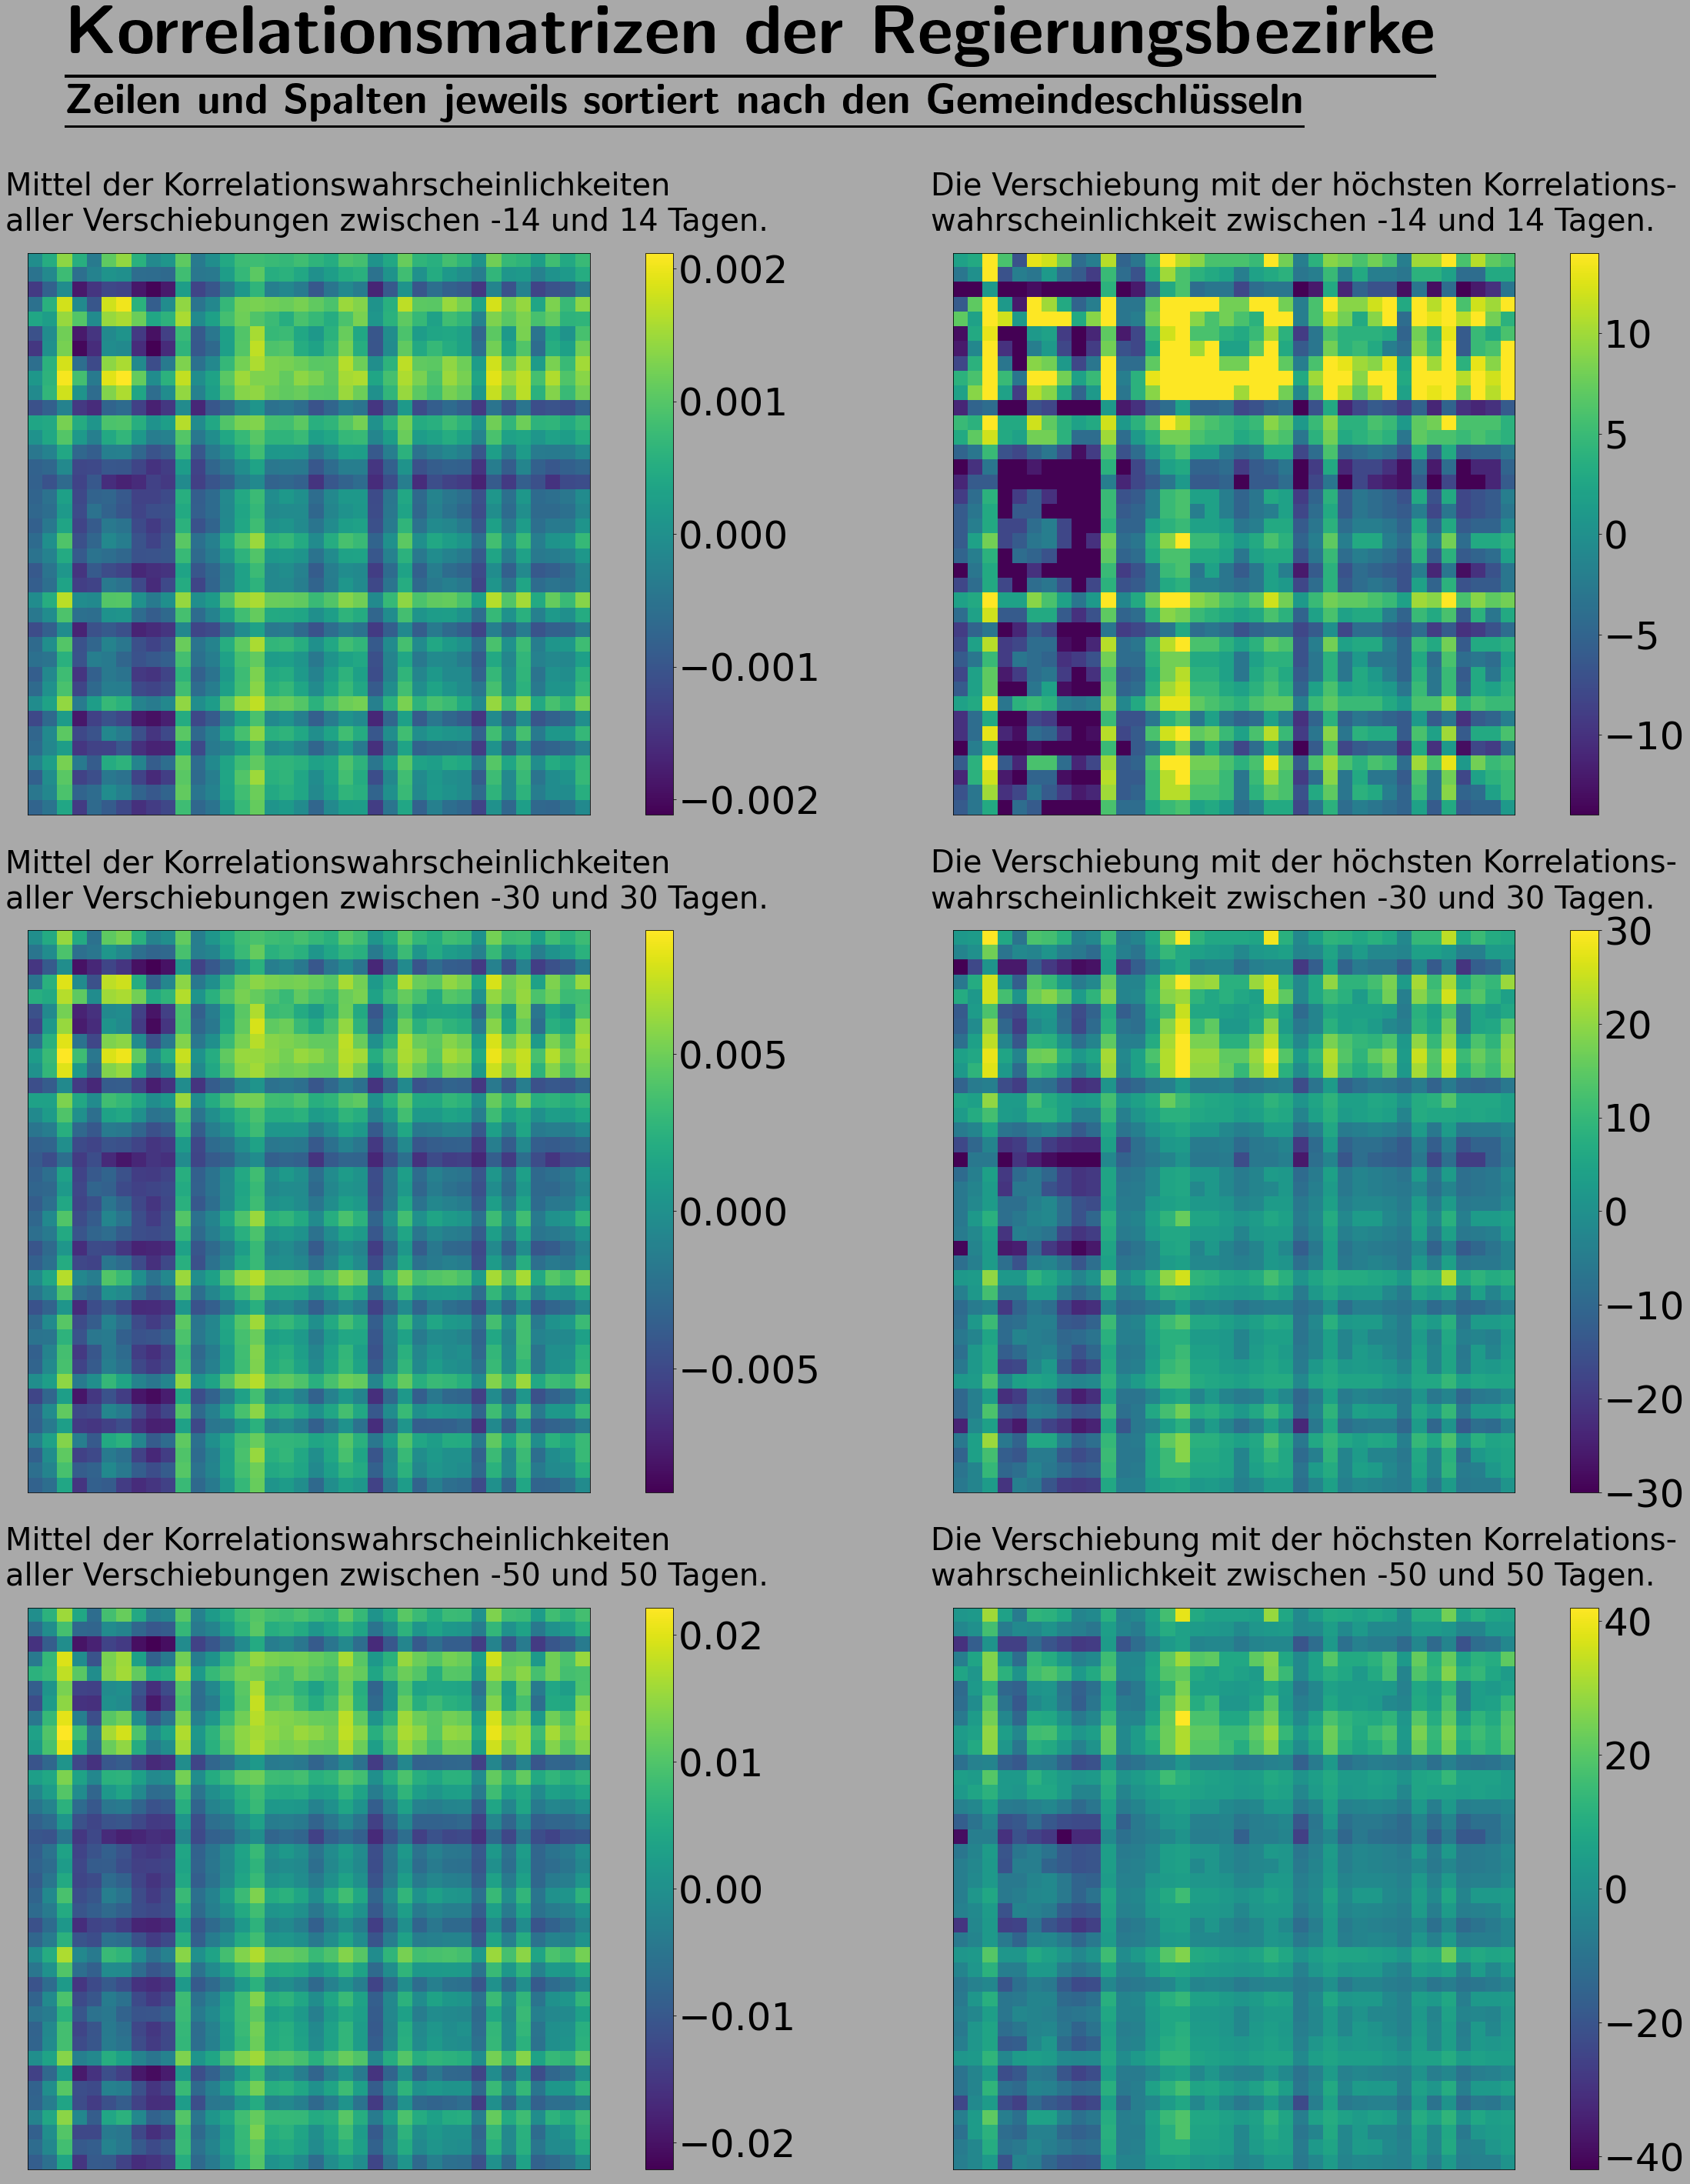

In [9]:
fig, ax = plt.subplots(3, 2, figsize = (35, 40), facecolor='darkgrey')
fig.tight_layout(h_pad=15)

ax[0][0].text(2,-14,r'\textbf{\underline{Korrelationsmatrizen der Regierungsbezirke}}',
              fontsize=90, usetex=True)
ax[0][0].text(2,-10,r'\textbf{\underline{Zeilen und Spalten jeweils sortiert nach den Gemeindeschlüsseln}}',
              fontsize=55, usetex=True)

i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//2][i%2]
    im1 = axis.matshow(correlation_matrix, interpolation='None')
    if matrix_configurations[i][0]:
        shift = str(matrix_configurations[i][1])
        axis.text(-2,-2,"Die Verschiebung mit der höchsten Korrelations-\n" +
                        "wahrscheinlichkeit zwischen -"+shift+" und "+shift+" Tagen.",
                        fontsize=40)
    else:
        shift = str(matrix_configurations[i][1])
        axis.text(-2,-2,"Mittel der Korrelationswahrscheinlichkeiten\n" +
                       "aller Verschiebungen zwischen -"+shift+" und "+shift+" Tagen.",
                       fontsize=40)
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=1)
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=50)
    i+=1

os.chdir(".."), os.chdir(".."), os.chdir("..")    # move to correct directory
# check if the needed directory is available - otherwise create it
if not(os.path.isdir("results")): os.makedirs("results")
fig.tight_layout(w_pad=-75)
plt.savefig("results/matrizes_north_to_south_districts.png")
os.chdir(cor_mx_north_south_directory)    # return to original directory